# import libraries

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [5]:
from scipy import stats

In [6]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
import pingouin as pg

In [8]:
import censusdata

# data collection

## retrieve county-level inequality data

### define collection function ```CensusGini```

In [8]:
def CensusGini(year, est):
    df_gini = censusdata.download(est, year, censusdata.censusgeo([('county','*')]), 
                                   ['GEO_ID','B19083_001E','B19013_001E','B01003_001E']) ## also retrive the median household income in the past 12 months and population
    
    county = df_gini.reset_index()['index'].apply(lambda x: str(x).split(",")[0]).tolist()
    state = df_gini.reset_index()['index'].apply(lambda x: str(x).split(",")[1].split(':')[0].strip()).tolist()

    df_gini['County'] = county
    df_gini['State'] = state
    df_gini['Year'] = np.repeat(year,df_gini.shape[0])
    
    df_gini.rename(columns = {'GEO_ID':'GEO_ID','B19083_001E':'gini','B19013_001E':'income','B01003_001E':'population'},inplace=True)
    df_gini.reset_index(inplace = True)
    df_gini.drop(columns=['index'],inplace = True)
    
    return(df_gini)

### collect county-level Gini indice

In [9]:
df_gini = pd.DataFrame()

for i in range(2010,2020):
    df_temp = CensusGini(i,'acs5')
    df_gini = pd.concat([df_gini,df_temp])

In [10]:
df_gini.sort_values(by = ['GEO_ID','Year'], inplace = True)

In [11]:
#drop PR

df_gini = df_gini[df_gini['State'] != 'Puerto Rico']

## retrieve ten-year county-level education data

### define collection function ```CensusEdu``` for collecting S1501 and S1401

In [12]:
def CensusEdu(year, var_dict, est):
    
    variable_list = ",".join([key for key in var_dict.keys()])
    
    url = 'https://api.census.gov/data/'+year+'/acs/'+est+'/subject?get=NAME,GEO_ID,'+variable_list+'&for=county:*'
    
    df_edu = pd.read_json(url)
    df_edu = df_edu.rename(columns=df_edu.iloc[0]).drop(df_edu.index[0])
    df_edu = df_edu.rename(columns = var_dict)
    
    df_edu['County']= df_edu.NAME.apply(lambda x: x.split(',')).apply(lambda y:y[0])
    df_edu['State']= df_edu.NAME.apply(lambda x: x.split(',')).apply(lambda y:y[1].strip())
    df_edu['Year'] = int(year)
    
    return df_edu

### collect Education Attainment (S1501)

#### create variable dictionaries

In [13]:
#dictionary for year 2010-2014
edu_attain_dict1 = {'S1501_C01_001E':'pop_total_18_24',
                    'S1501_C01_016E':'pop_total_25_34',
                    'S1501_C01_006E':'pop_total_25_plus',
                    
                    'S1501_C01_003E':'hs_18_24',
                    'S1501_C01_004E':'some_college_asso_18_24',
                    'S1501_C01_005E':'ba_higher_18_24',
                     
                    'S1501_C01_009E':'hs_25_plus',
                    'S1501_C01_010E':'some_college_25_plus',
                    'S1501_C01_011E':'asso_25_plus',
                    'S1501_C01_012E':'ba_25_plus',
                    'S1501_C01_013E':'grad_prof_25_plus', 
                     
                    'S1501_C01_014E':'hs_higher_25_plus',
                    'S1501_C01_015E':'ba_higher_25_plus',
                    
                    'S1501_C01_017E':'hs_higher_25_34', 
                    'S1501_C01_018E':'ba_higher_25_34'} 

In [ ]:
#dictionary for 2015-2019
edu_attain_dict2 = {'S1501_C01_001E':'pop_total_18_24',
                    'S1501_C01_016E':'pop_total_25_34',
                    'S1501_C01_006E':'pop_total_25_plus',
                    
                    'S1501_C02_003E':'hs_18_24',
                    'S1501_C02_004E':'some_college_asso_18_24',
                    'S1501_C02_005E':'ba_higher_18_24',
                    
                    'S1501_C02_009E':'hs_25_plus',
                    'S1501_C02_010E':'some_college_25_plus',
                    'S1501_C02_011E':'asso_25_plus',
                    'S1501_C02_012E':'ba_25_plus',
                    'S1501_C02_013E':'grad_prof_25_plus',
                    
                    'S1501_C02_014E':'hs_higher_25_plus',
                    'S1501_C02_015E':'ba_higher_25_plus',
                    
                    'S1501_C02_017E':'hs_higher_25_34',
                    'S1501_C02_018E':'ba_higher_25_34'}

#### define collcetion function ```CollectAttainData```

In [168]:
#define the collection function
def CollectAttainData(est):
    df_edu_attain1 = pd.DataFrame()
    df_edu_attain2 = pd.DataFrame()
    
    for i in range(2010,2015):
        df_temp = CensusEdu(str(i), edu_attain_dict1, est)
        df_edu_attain1 = pd.concat([df_edu_attain1, df_temp])
        
    for i in range(2015,2020):
        df_temp = CensusEdu(str(i), edu_attain_dict2, est)
        df_edu_attain2 = pd.concat([df_edu_attain2, df_temp])
        
    df_edu_attain = pd.concat([df_edu_attain1,df_edu_attain2],axis = 0).sort_values(by = ['GEO_ID','Year'])
    
    df_edu_attain[df_edu_attain.columns[2:17]] = df_edu_attain[df_edu_attain.columns[2:17]].astype('float')
    
    df_edu_attain['Year'] = df_edu_attain['Year'].astype('int')
    df_edu_attain['state'] = df_edu_attain['state'].astype('int')
    df_edu_attain['county'] = df_edu_attain['county'].astype('int')
    
    
    return df_edu_attain

##### collect one-year estimates

In [94]:
#collect 1y-est
df_edu_attain_1y = CollectAttainData('acs1')

In [95]:
df_edu_attain_1y.head()

,NAME,GEO_ID,pop_total_18_24,pop_total_25_34,pop_total_25_plus,hs_18_24,some_college_asso_18_24,ba_higher_18_24,hs_25_plus,some_college_25_plus,...,grad_prof_25_plus,hs_higher_25_plus,ba_higher_25_plus,hs_higher_25_34,ba_higher_25_34,state,county,County,State,Year
130,"Baldwin County, Alabama",0500000US01003,13087.0,21568.0,127969.0,34.7,32.2,10.7,30.7,22.0,...,7.4,87.7,27.2,80.8,29.8,1,3,Baldwin County,Alabama,2010
385,"Baldwin County, Alabama",0500000US01003,13225.0,23402.0,131214.0,38.5,40.2,8.9,29.9,23.9,...,9.9,90.4,28.3,94.4,25.6,1,3,Baldwin County,Alabama,2011
328,"Baldwin County, Alabama",0500000US01003,14842.0,22639.0,133433.0,31.4,51.0,3.7,28.4,23.7,...,10.0,89.2,29.1,80.4,19.3,1,3,Baldwin County,Alabama,2012
696,"Baldwin County, Alabama",0500000US01003,16219.0,23066.0,135016.0,32.6,30.2,11.6,29.3,22.0,...,9.2,90.6,29.0,89.1,25.9,1,3,Baldwin County,Alabama,2013
217,"Baldwin County, Alabama",0500000US01003,14901.0,23464.0,140588.0,33.6,28.9,8.6,25.5,23.4,...,10.5,89.0,30.5,83.1,31.8,1,3,Baldwin County,Alabama,2014


In [96]:
df_edu_attain_1y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8297 entries, 130 to 374
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NAME                     8297 non-null   object 
 1   GEO_ID                   8297 non-null   object 
 2   pop_total_18_24          8297 non-null   float64
 3   pop_total_25_34          8297 non-null   float64
 4   pop_total_25_plus        8297 non-null   float64
 5   hs_18_24                 8297 non-null   float64
 6   some_college_asso_18_24  8297 non-null   float64
 7   ba_higher_18_24          8297 non-null   float64
 8   hs_25_plus               8297 non-null   float64
 9   some_college_25_plus     8297 non-null   float64
 10  asso_25_plus             8297 non-null   float64
 11  ba_25_plus               8297 non-null   float64
 12  grad_prof_25_plus        8297 non-null   float64
 13  hs_higher_25_plus        8297 non-null   float64
 14  ba_higher_25_plus      

##### collect five-year estimates

In [102]:
df_edu_attain_5y = CollectAttainData('acs5')

In [103]:
df_edu_attain_5y.head()

,NAME,GEO_ID,pop_total_18_24,pop_total_25_34,pop_total_25_plus,hs_18_24,some_college_asso_18_24,ba_higher_18_24,hs_25_plus,some_college_25_plus,...,grad_prof_25_plus,hs_higher_25_plus,ba_higher_25_plus,hs_higher_25_34,ba_higher_25_34,state,county,County,State,Year
80,"Autauga County, Alabama",0500000US01001,4546.0,6370.0,33884.0,33.0,37.2,6.4,35.2,21.9,...,7.1,85.3,21.7,87.5,22.3,1,1,Autauga County,Alabama,2010
2261,"Autauga County, Alabama",0500000US01001,4655.0,6466.0,34581.0,36.7,34.8,5.4,35.0,22.2,...,6.9,86.5,21.6,88.9,22.5,1,1,Autauga County,Alabama,2011
3211,"Autauga County, Alabama",0500000US01001,4809.0,6452.0,35144.0,36.8,38.2,4.0,33.8,22.0,...,7.2,85.1,21.7,84.1,21.9,1,1,Autauga County,Alabama,2012
2407,"Autauga County, Alabama",0500000US01001,4819.0,6540.0,35696.0,37.7,37.9,4.5,34.2,23.1,...,7.2,85.6,20.9,86.6,22.4,1,1,Autauga County,Alabama,2013
2073,"Autauga County, Alabama",0500000US01001,4689.0,6696.0,36233.0,37.7,36.8,4.4,33.5,22.9,...,8.3,86.2,21.9,89.0,24.3,1,1,Autauga County,Alabama,2014


In [119]:
df_edu_attain_5y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32236 entries, 80 to 37
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NAME                     32236 non-null  object 
 1   GEO_ID                   32236 non-null  object 
 2   pop_total_18_24          32204 non-null  float64
 3   pop_total_25_34          32204 non-null  float64
 4   pop_total_25_plus        32204 non-null  float64
 5   hs_18_24                 32204 non-null  float64
 6   some_college_asso_18_24  32204 non-null  float64
 7   ba_higher_18_24          32204 non-null  float64
 8   hs_25_plus               32204 non-null  float64
 9   some_college_25_plus     32204 non-null  float64
 10  asso_25_plus             32204 non-null  float64
 11  ba_25_plus               32204 non-null  float64
 12  grad_prof_25_plus        32204 non-null  float64
 13  hs_higher_25_plus        32204 non-null  float64
 14  ba_higher_25_plus       

### collect one-year School Enrollment (S1401)

#### create variable dictionary

In [33]:
#### dictionary for year 2010-2014
edu_enroll_dict1 = {'S1401_C01_001E':'pop_total_3_plus',
                    'S1401_C01_008E':'pop_college_3_plus',
                    'S1401_C01_009E':'pop_grad_prof_3_plus',
                    
                    'S1401_C01_025E':'college_grad_18_24'} 

In [ ]:
#dictionary for year 2015-2019
edu_enroll_dict2 = {'S1401_C01_001E':'pop_total_3_plus',
                    'S1401_C02_008E':'college_3_plus',
                    'S1401_C02_009E':'grad_prof_3_plus',
                    
                    'S1401_C02_030E':'college_grad_18_24'} 

#### define the collection function

In [110]:
#define the collection function
def CollectEnrollData(est):
    df_edu_enroll1 = pd.DataFrame()
    df_edu_enroll2 = pd.DataFrame()
    
    for i in range(2010,2015):
        df_temp = CensusEdu(str(i), edu_enroll_dict1, est)
        df_edu_enroll1 = pd.concat([df_edu_enroll1, df_temp])
        
    for i in range(2015,2020):
        df_temp = CensusEdu(str(i), edu_enroll_dict2, est)
        df_edu_enroll2 = pd.concat([df_edu_enroll2, df_temp])
    
    df_edu_enroll1[df_edu_enroll1.columns[2:5]] = df_edu_enroll1[df_edu_enroll1.columns[2:5]].astype('float')
    
    df_edu_enroll1['college_3_plus'] = np.round(df_edu_enroll1['pop_college_3_plus']/df_edu_enroll1['pop_total_3_plus']*100,1)
    df_edu_enroll1['grad_prof_3_plus'] = np.round(df_edu_enroll1['pop_grad_prof_3_plus']/df_edu_enroll1['pop_total_3_plus']*100,1)
    df_edu_enroll1.drop(['pop_college_3_plus','pop_grad_prof_3_plus'],axis = 1, inplace = True)
    
    df_edu_enroll = pd.concat([df_edu_enroll1,df_edu_enroll2],axis = 0).sort_values(by = ['GEO_ID','Year'])
    
    df_edu_enroll[df_edu_enroll.columns[2:4]] = df_edu_enroll[df_edu_enroll.columns[2:4]].astype('float')
    df_edu_enroll[df_edu_enroll.columns[-2:]] = df_edu_enroll[df_edu_enroll.columns[-2:]].astype('float')
    
    df_edu_enroll['Year'] = df_edu_enroll['Year'].astype('int')
    df_edu_enroll['state'] = df_edu_enroll['state'].astype('int')
    df_edu_enroll['county'] = df_edu_enroll['county'].astype('int')
    
    return df_edu_enroll

##### collect one-year estimate

In [111]:
#collect one-year estimate
df_edu_enroll_1y = CollectEnrollData('acs1')

In [112]:
df_edu_enroll_1y.head()

,NAME,GEO_ID,pop_total_3_plus,college_grad_18_24,state,county,County,State,Year,college_3_plus,grad_prof_3_plus
130,"Baldwin County, Alabama",0500000US01003,42673.0,32.4,1,3,Baldwin County,Alabama,2010,17.2,4.3
385,"Baldwin County, Alabama",0500000US01003,43055.0,28.2,1,3,Baldwin County,Alabama,2011,17.7,1.3
328,"Baldwin County, Alabama",0500000US01003,44159.0,41.1,1,3,Baldwin County,Alabama,2012,22.2,2.0
696,"Baldwin County, Alabama",0500000US01003,42227.0,21.5,1,3,Baldwin County,Alabama,2013,12.9,2.6
217,"Baldwin County, Alabama",0500000US01003,45836.0,27.1,1,3,Baldwin County,Alabama,2014,15.0,6.6


In [113]:
df_edu_enroll_1y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8297 entries, 130 to 374
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NAME                8297 non-null   object 
 1   GEO_ID              8297 non-null   object 
 2   pop_total_3_plus    8297 non-null   float64
 3   college_grad_18_24  7948 non-null   float64
 4   state               8297 non-null   int64  
 5   county              8297 non-null   int64  
 6   County              8297 non-null   object 
 7   State               8297 non-null   object 
 8   Year                8297 non-null   int64  
 9   college_3_plus      8297 non-null   float64
 10  grad_prof_3_plus    8297 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 777.8+ KB


##### collect five-year estimate

In [115]:
#collect five-year estimate
df_edu_enroll_5y = CollectEnrollData('acs5')

In [116]:
df_edu_enroll_5y.head()

,NAME,GEO_ID,pop_total_3_plus,college_grad_18_24,state,county,County,State,Year,college_3_plus,grad_prof_3_plus
80,"Autauga County, Alabama",0500000US01001,15215.0,34.4,1,1,Autauga County,Alabama,2010,15.8,4.4
2261,"Autauga County, Alabama",0500000US01001,15268.0,31.5,1,1,Autauga County,Alabama,2011,16.2,4.0
3211,"Autauga County, Alabama",0500000US01001,15669.0,32.7,1,1,Autauga County,Alabama,2012,17.1,4.1
2407,"Autauga County, Alabama",0500000US01001,15314.0,29.6,1,1,Autauga County,Alabama,2013,17.4,3.7
2073,"Autauga County, Alabama",0500000US01001,14765.0,24.3,1,1,Autauga County,Alabama,2014,16.1,3.8


In [118]:
df_edu_enroll_5y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32236 entries, 80 to 37
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NAME                32236 non-null  object 
 1   GEO_ID              32236 non-null  object 
 2   pop_total_3_plus    32204 non-null  float64
 3   college_grad_18_24  32204 non-null  float64
 4   state               32236 non-null  int64  
 5   county              32236 non-null  int64  
 6   County              32236 non-null  object 
 7   State               32236 non-null  object 
 8   Year                32236 non-null  int64  
 9   college_3_plus      32202 non-null  float64
 10  grad_prof_3_plus    32202 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 3.0+ MB


## create the master datasets

### merge datasets

In [54]:
#import unemployment data
df_un_master = pd.read_csv('df_un_master.csv')
df_un_master.head()

,LAUS,state,county,County Name/State Abbreviation,Year,force,employed,unemployed,unemployment
0,CN0100100000000,1,1,"Autauga County, AL",2010,25749,23481,2268,8.8
1,CN0100300000000,1,3,"Baldwin County, AL",2010,83551,75283,8268,9.9
2,CN0100500000000,1,5,"Barbour County, AL",2010,10219,8978,1241,12.1
3,CN0100700000000,1,7,"Bibb County, AL",2010,8936,7931,1005,11.2
4,CN0100900000000,1,9,"Blount County, AL",2010,24928,22509,2419,9.7


In [169]:
def CreateMaster(df_edu):
    df_master = df_edu.merge(df_gini,on = ['GEO_ID','Year','County','State'],how = 'inner').merge(df_un_master)
    
    df_master = df_master.replace(-666666666.0, np.nan)
    df_master = df_master.replace(-999999999.0, np.nan)
    
    return df_master

In [170]:
df_attain_master_1y = CreateMaster(df_edu_attain_1y)

In [171]:
df_attain_master_5y = CreateMaster(df_edu_attain_5y)

In [172]:
df_enroll_master_1y = CreateMaster(df_edu_enroll_1y)

In [173]:
df_enroll_master_5y = CreateMaster(df_edu_enroll_5y)

In [339]:
df_list = [df_attain_master_1y, df_attain_master_5y,df_enroll_master_1y, df_enroll_master_5y]
df_des_list = ['one-year estimated education attainment data','five-year estimated education attainment data',
               'one-year estimated school enrollmentt data','five-year estimated school enrollment data']

### calculate decimal DVs ```CalDecimal```

In [ ]:
def CalDecimal(df, dv):
    dv_decimal= dv + 'D'
    df[dv_decimal] = df[dv].apply(lambda x: x/100) 

In [202]:
for df in df_list[0:2]:
    for dv in list(df.columns[5:17]):
        CalDecimal(df, dv)

In [160]:
df_list[0].columns[5:17]

Index(['hs_18_24', 'some_college_asso_18_24', 'ba_higher_18_24', 'hs_25_plus',
       'some_college_25_plus', 'asso_25_plus', 'ba_25_plus',
       'grad_prof_25_plus', 'hs_higher_25_plus', 'ba_higher_25_plus',
       'hs_higher_25_34', 'ba_higher_25_34'],
      dtype='object')

In [203]:
for df in df_list[2:4]:
    for dv in ['college_grad_18_24','college_3_plus','grad_prof_3_plus']:
        CalDecimal(df, dv)

### calculate year difference ```CalDvDiff```

In [381]:
def CalDvDiff(df, dv):
    df_diff = pd.DataFrame()
    df_temp = pd.DataFrame()
    
    var_diff = dv + '_diff'
    
    for county in df['GEO_ID'].unique():
        for year in np.arange(2011,2020):
            try:
                current_year  =  df.loc[(df['Year'] == year) & (df['GEO_ID'] == county), dv].values[0]
                previous_year =  df.loc[(df['Year'] == year-1) & (df['GEO_ID'] == county), dv].values[0]
                if previous_year != 0:
                    diff_county_year = (current_year - previous_year)/previous_year
                else:
                    diff_county_year = np.nan
                    
                
                df_temp = pd.DataFrame({'Year': [year], 'GEO_ID': [county], var_diff: [diff_county_year]})
                df_diff = pd.concat([df_diff, df_temp], ignore_index = True)
            except IndexError:
                pass
            
            
    return df_diff

In [362]:
attain_dv_list = list(df_attain_master_1y.columns[5:17]) + list(df_attain_master_1y.columns[31:43])

In [394]:
df_attain_master_1y[['ba_higher_18_24','ba_higher_18_24_diff']].describe()

,ba_higher_18_24,ba_higher_18_24_diff
count,8186.000000,7354.000000
mean,9.038370,0.270873
std,5.425276,3.708533
min,0.000000,-22.400000
25%,5.300000,-1.800000
50%,8.300000,0.300000
75%,11.800000,2.400000
max,60.200000,27.500000


In [363]:
for dv in attain_dv_list:
    df_attain_master_1y = CalDvDiff(df_attain_master_1y, dv)

In [382]:
for dv in ['college_grad_18_24','college_3_plus','grad_prof_3_plus']:
           #college_grad_18_24D','college_3_plusD','grad_prof_3_plusD']:
    df_enroll_master_1y_diff =  CalDvDiff(df_enroll_master_1y, dv)

### calculate log-income

In [201]:
for df in df_list:
    df['log10_income'] = df['income'].apply(lambda x: np.log10(1+x))

## check master datasets

### check sample information ```CheckSample```

In [177]:
def CheckSample(df, df_des):
    N = df.shape[0]
    N_county = df.GEO_ID.unique().size
    N_state = df.State.unique().size
    
    print('Sample information for {}:'.format(df_des))
    print('N = {}, N of county = {} and N of state = {}'.format(N, N_county, N_state))
    print('\n')

In [178]:
df_list = [df_attain_master_1y, df_attain_master_5y,df_enroll_master_1y, df_enroll_master_5y]
df_des_list = ['one-year estimated education attainment data','five-year estimated education attainment data',
               'one-year estimated school enrollmentt data','five-year estimated school enrollment data']

for df, df_des in zip(df_list, df_des_list):
    CheckSample(df, df_des)

Sample information for one-year estimated education attainment data:
N = 8186, N of county = 831 and N of state = 51


Sample information for five-year estimated education attainment data:
N = 31400, N of county = 3141 and N of state = 51


Sample information for one-year estimated school enrollmentt data:
N = 8186, N of county = 831 and N of state = 51


Sample information for five-year estimated school enrollment data:
N = 31400, N of county = 3141 and N of state = 51




### check counties/states with missing data ```Count_w_Missing```

In [179]:
def Count_w_Missing(df, df_des, count):
    count_results = df.groupby('GEO_ID')['Year'].count()
    df_count = pd.DataFrame(count_results).reset_index().rename(columns = {"Year": 'count'})
    df_missing_temp = df_count[df_count['count'] != count]
    df_missing = df_missing_temp.merge(df)
    
    N_county_w_missing = df_missing.GEO_ID.unique().size
    N_state_w_missing = df_missing.State.unique().size
    
    print('Missing information for {}:'.format(df_des))
    print('N of county with missing data = {} and N of state with missing data = {}'.format(N_county_w_missing, N_state_w_missing))
    print('\n')

In [180]:
for df, df_des in zip(df_list, df_des_list):
    Count_w_Missing(df, df_des, 10)

Missing information for one-year estimated education attainment data:
N of county with missing data = 26 and N of state with missing data = 16


Missing information for five-year estimated education attainment data:
N of county with missing data = 2 and N of state with missing data = 2


Missing information for one-year estimated school enrollmentt data:
N of county with missing data = 26 and N of state with missing data = 16


Missing information for five-year estimated school enrollment data:
N of county with missing data = 2 and N of state with missing data = 2




### check distribution of variables ```CheckDist```

In [187]:
def CheckDist(df, df_des, dv):
    plt.hist(df[dv], 20)
    
    plt.title('Distribution of {} \n (data: {})'.format(dv, df_des))
    
    plt.show()

##### check dvs of education attainment

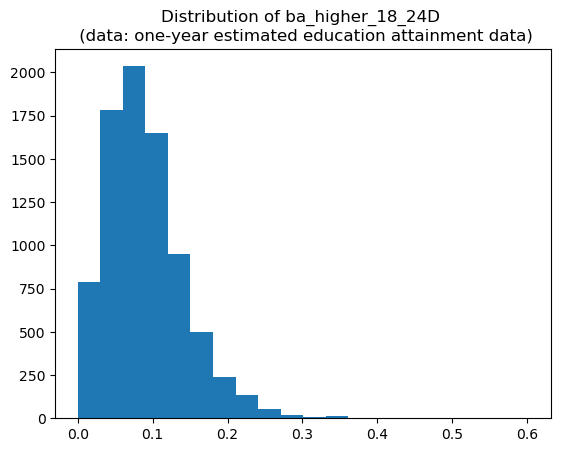

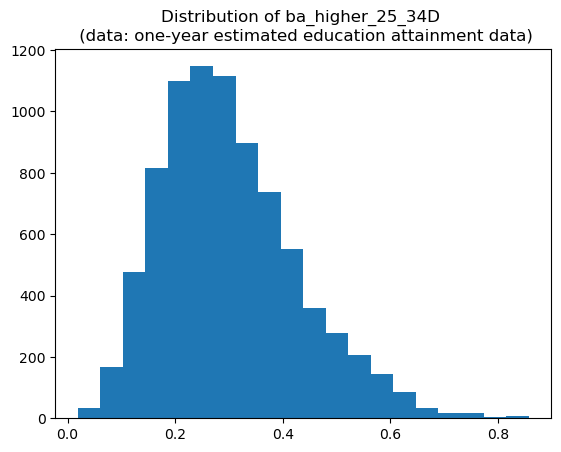

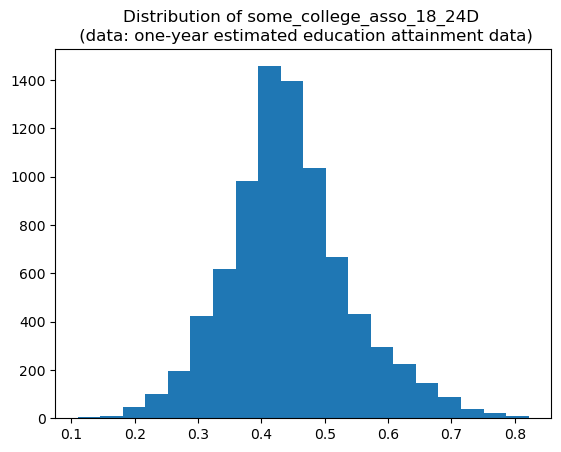

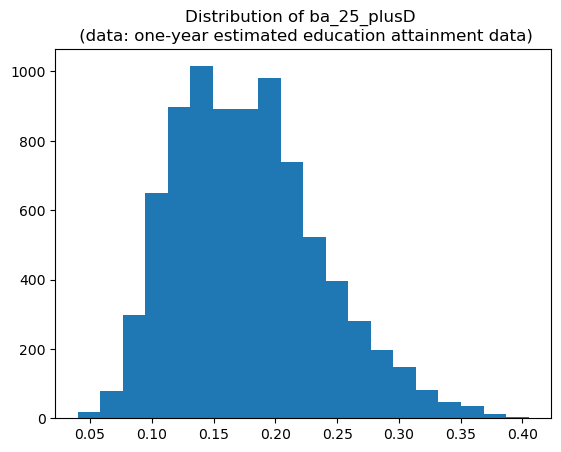

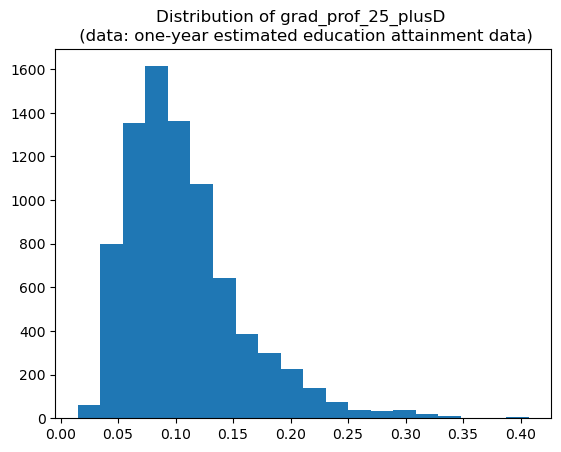

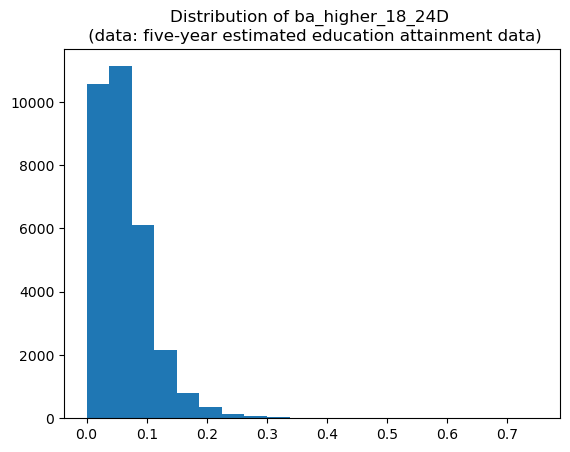

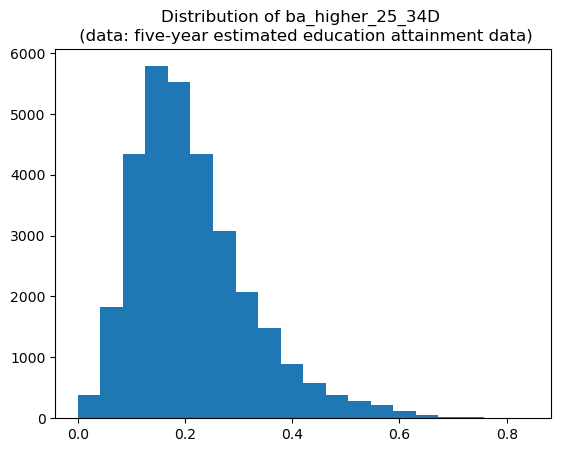

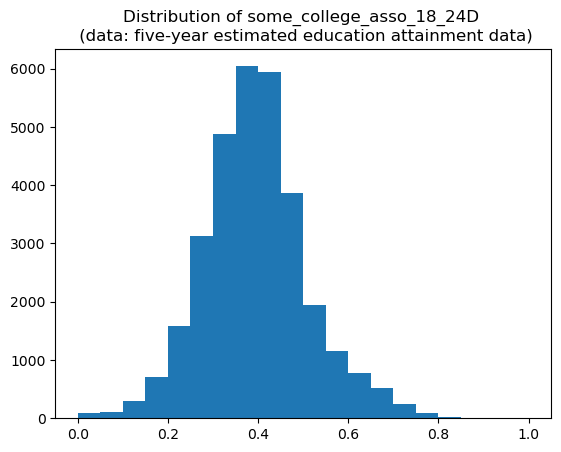

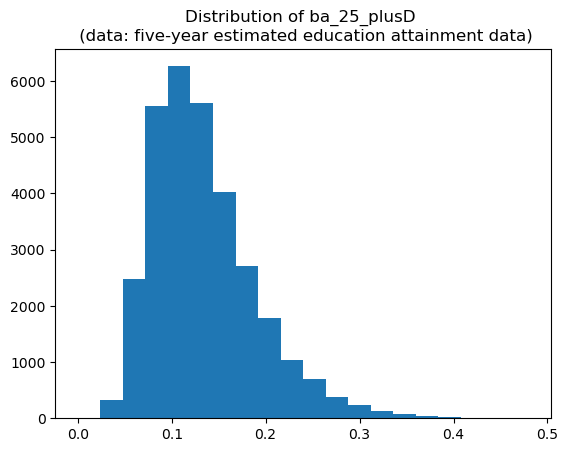

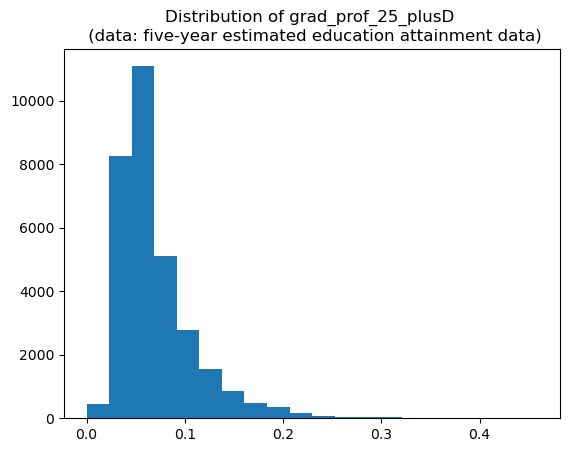

In [190]:
dv_attain = ['ba_higher_18_24D','ba_higher_25_34D',
             'some_college_asso_18_24D',
             'ba_25_plusD','grad_prof_25_plusD']


df_attain = df_list[0:2]
df_des_attain = df_des_list[0:2]

for df, df_des in zip(df_attain, df_des_attain):
    for dv in dv_attain:
        CheckDist(df, df_des, dv)

##### check dv of school enrollment

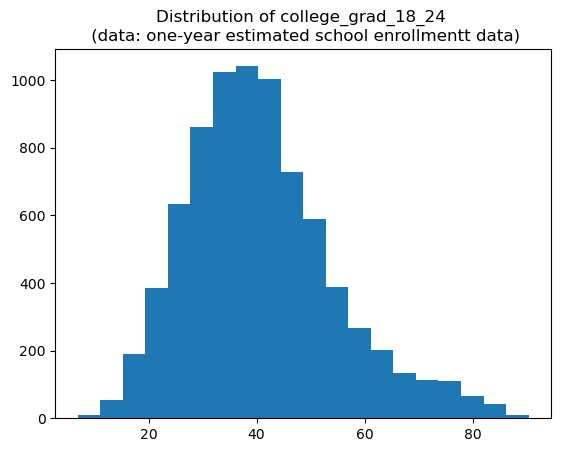

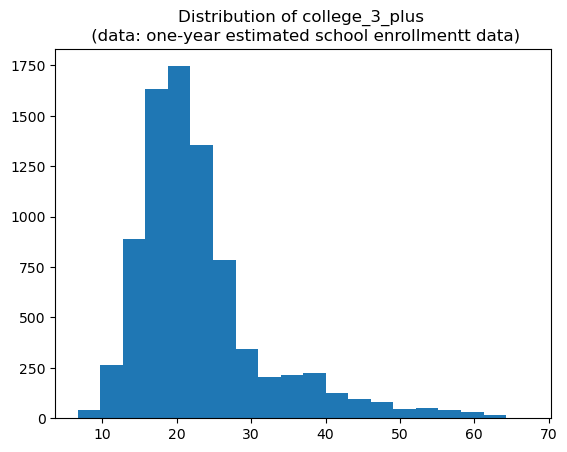

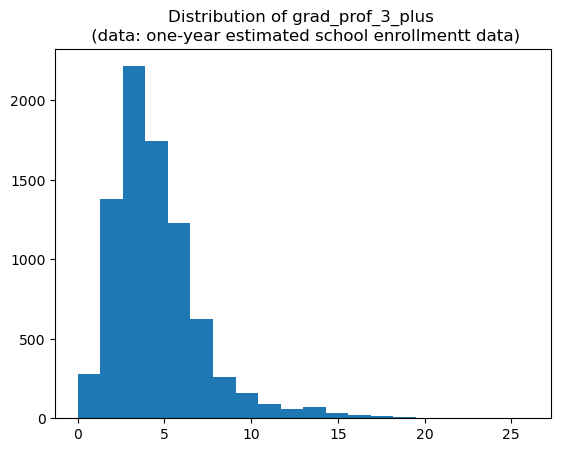

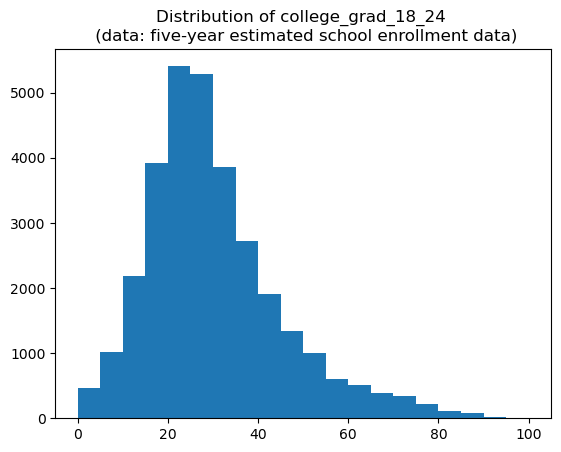

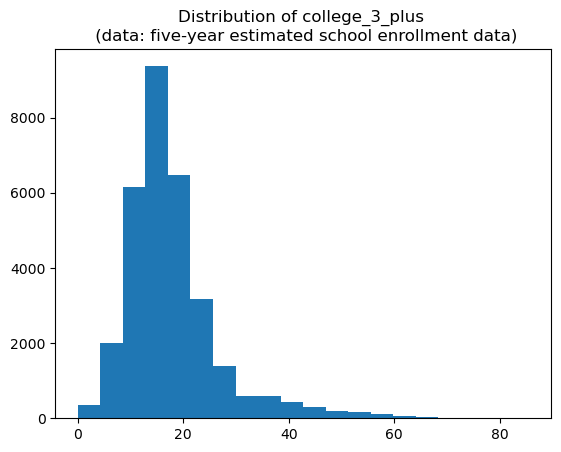

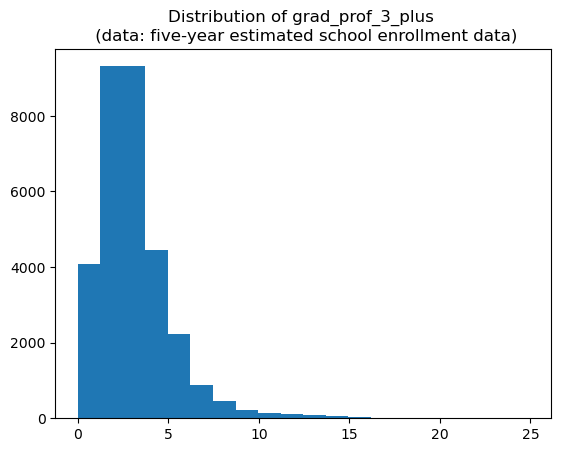

In [199]:
dv_enroll = ['college_grad_18_24',
             'college_3_plus',
             'grad_prof_3_plus']


df_enroll = df_list[2:4]
df_des_enroll = df_des_list[2:4]

for df, df_des in zip(df_enroll, df_des_enroll):
    for dv in dv_enroll:
        CheckDist(df, df_des, dv)

## save the master datasets

In [205]:
def SaveData(df, df_name):
    df_path = df_name + '.csv'
    df.to_csv(df_path, index = False)

In [206]:
df_name_list = ['df_attain_master_1y','df_attain_master_5y','df_enroll_master_1y','df_enroll_master_5y']

for df, df_name in zip(df_list, df_name_list):
    SaveData(df, df_name)

In [400]:
df_attain_master_1y.describe()

,pop_total_18_24,pop_total_25_34,pop_total_25_plus,hs_18_24,some_college_asso_18_24,ba_higher_18_24,hs_25_plus,some_college_25_plus,asso_25_plus,ba_25_plus,...,ba_higher_18_24D_diff,hs_25_plusD_diff,some_college_25_plusD_diff,asso_25_plusD_diff,ba_25_plusD_diff,grad_prof_25_plusD_diff,hs_higher_25_plusD_diff,ba_higher_25_plusD_diff,hs_higher_25_34D_diff,ba_higher_25_34D_diff
count,8.186000e+03,8.186000e+03,8.186000e+03,8186.000000,8186.000000,8186.000000,8186.000000,8186.000000,8186.000000,8186.000000,...,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000
mean,3.250947e+04,4.622439e+04,2.212228e+05,32.326228,44.417982,9.038370,29.353958,21.672013,8.724383,17.792108,...,0.002709,-0.001506,-0.001373,0.001282,0.002470,0.002263,0.003132,0.004730,0.004052,0.004566
std,5.707605e+04,9.081433e+04,3.887380e+05,8.194419,9.744485,5.425276,6.923328,3.949012,2.102176,5.868887,...,0.037085,0.023381,0.021241,0.013673,0.017554,0.013730,0.017354,0.021229,0.040240,0.053582
min,3.049000e+03,4.980000e+03,3.498200e+04,5.500000,11.000000,0.000000,6.600000,6.600000,2.300000,4.000000,...,-0.224000,-0.111000,-0.107000,-0.071000,-0.070000,-0.119000,-0.081000,-0.091000,-0.191000,-0.261000
25%,9.084500e+03,1.159925e+04,6.375825e+04,27.000000,38.400000,5.300000,24.700000,19.100000,7.300000,13.300000,...,-0.018000,-0.015000,-0.013000,-0.007000,-0.008000,-0.006000,-0.007000,-0.007000,-0.017000,-0.026000
50%,1.564050e+04,1.946950e+04,1.047845e+05,32.000000,43.700000,8.300000,29.300000,21.700000,8.600000,17.200000,...,0.003000,-0.002000,-0.002000,0.001000,0.002000,0.002000,0.003000,0.005000,0.004000,0.005000
75%,3.588850e+04,4.371125e+04,2.189388e+05,37.300000,49.500000,11.800000,33.800000,24.200000,10.000000,21.400000,...,0.024000,0.012000,0.011000,0.009000,0.013000,0.010000,0.013000,0.017000,0.025000,0.036000
max,1.077469e+06,1.640038e+06,6.961614e+06,67.400000,82.200000,60.200000,53.000000,36.300000,18.100000,40.500000,...,0.275000,0.109000,0.104000,0.074000,0.093000,0.066000,0.086000,0.118000,0.251000,0.292000


(array([ 860., 2964., 2435., 1033.,  527.,  213.,   72.,   59.,   15.,
           8.]),
 array([ 1.5 ,  5.42,  9.34, 13.26, 17.18, 21.1 , 25.02, 28.94, 32.86,
        36.78, 40.7 ]),
 <BarContainer object of 10 artists>)

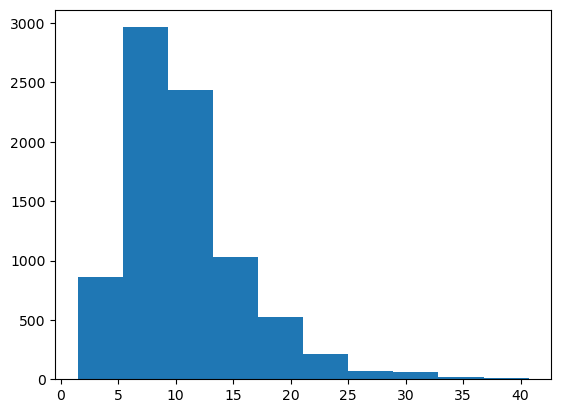

In [399]:
plt.hist(df_attain_master_1y.grad_prof_25_plus)

In [145]:
test = df_attain_master_1y.head(100)[['NAME','GEO_ID','ba_higher_18_24','Year','County','State','county','state','gini']]

In [146]:
test

,NAME,GEO_ID,ba_higher_18_24,Year,County,State,county,state,gini
0,"Baldwin County, Alabama",0500000US01003,10.7,2010,Baldwin County,Alabama,3,1,0.4390
1,"Baldwin County, Alabama",0500000US01003,8.9,2011,Baldwin County,Alabama,3,1,0.4370
2,"Baldwin County, Alabama",0500000US01003,3.7,2012,Baldwin County,Alabama,3,1,0.4364
3,"Baldwin County, Alabama",0500000US01003,11.6,2013,Baldwin County,Alabama,3,1,0.4455
4,"Baldwin County, Alabama",0500000US01003,8.6,2014,Baldwin County,Alabama,3,1,0.4517
...,...,...,...,...,...,...,...,...,...
95,"Lee County, Alabama",0500000US01081,9.5,2015,Lee County,Alabama,81,1,0.4976
96,"Lee County, Alabama",0500000US01081,16.8,2016,Lee County,Alabama,81,1,0.5003
97,"Lee County, Alabama",0500000US01081,6.9,2017,Lee County,Alabama,81,1,0.5008
98,"Lee County, Alabama",0500000US01081,10.1,2018,Lee County,Alabama,81,1,0.5081


In [125]:
result_df 

,Year,GEO_ID,diff
0,2011,0500000US01003,-1.8
0,2012,0500000US01003,-5.2
0,2013,0500000US01003,7.9
0,2014,0500000US01003,-3.0
0,2015,0500000US01003,0.7
...,...,...,...
0,2019,0500000US01081,-0.4
0,2019,0500000US01081,-0.4
0,2019,0500000US01081,-0.4
0,2019,0500000US01081,-0.4


In [132]:
result_df = pd.DataFrame()
temp_df = pd.DataFrame()

for county in test['GEO_ID'].unique():
    for year in np.arange(2011,2020): 
        previous_year =  test.loc[(test['Year'] == year-1) & (test['GEO_ID'] == county), 'ba_higher_18_24'].values[0]
        current_year  =  test.loc[(test['Year'] == year) & (test['GEO_ID'] == county), 'ba_higher_18_24'].values[0]
        year_diff = current_year -  previous_year
        
        temp_df = pd.DataFrame({'Year': [year], 'GEO_ID': [county], 'diff': [year_diff]})
        
        # Concatenate the temporary DataFrame with the result DataFrame
        result_df = pd.concat([result_df, temp_df])

In [149]:
df_diff = CalDvDiff(test, 'ba_higher_18_24')

In [151]:
test_new = test.merge(df_diff, how = 'outer').sort_values(by = ['state','county'])

In [139]:
import seaborn as sns

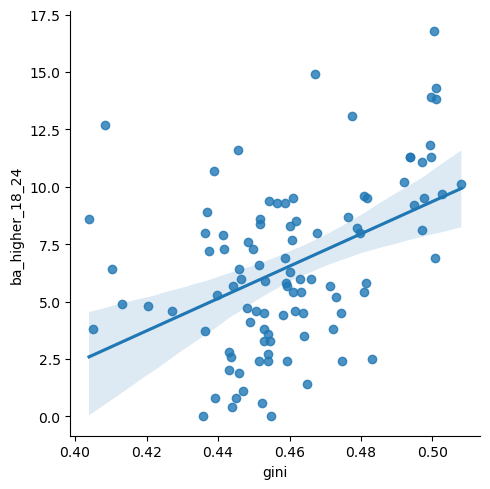

In [152]:
sns.lmplot(data = test_new, x ='gini', y = 'ba_higher_18_24')

In [140]:
df_attain_master_1y

,NAME,GEO_ID,pop_total_18_24,pop_total_25_34,pop_total_25_plus,hs_18_24,some_college_asso_18_24,ba_higher_18_24,hs_25_plus,some_college_25_plus,...,hs_25_plusD,some_college_25_plusD,asso_25_plusD,ba_25_plusD,grad_prof_25_plusD,hs_higher_25_plusD,ba_higher_25_plusD,hs_higher_25_34D,ba_higher_25_34D,log10_income
0,"Baldwin County, Alabama",0500000US01003,13087.0,21568.0,127969.0,34.7,32.2,10.7,30.7,22.0,...,0.307,0.220,0.078,0.198,0.074,0.877,0.272,0.808,0.298,4.700254
1,"Baldwin County, Alabama",0500000US01003,13225.0,23402.0,131214.0,38.5,40.2,8.9,29.9,23.9,...,0.299,0.239,0.084,0.184,0.099,0.904,0.283,0.944,0.256,4.710304
2,"Baldwin County, Alabama",0500000US01003,14842.0,22639.0,133433.0,31.4,51.0,3.7,28.4,23.7,...,0.284,0.237,0.080,0.191,0.100,0.892,0.291,0.804,0.193,4.705068
3,"Baldwin County, Alabama",0500000US01003,16219.0,23066.0,135016.0,32.6,30.2,11.6,29.3,22.0,...,0.293,0.220,0.103,0.197,0.092,0.906,0.290,0.891,0.259,4.700894
4,"Baldwin County, Alabama",0500000US01003,14901.0,23464.0,140588.0,33.6,28.9,8.6,25.5,23.4,...,0.255,0.234,0.095,0.200,0.105,0.890,0.305,0.831,0.318,4.700565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8181,"Natrona County, Wyoming",0500000US56025,7618.0,11716.0,53528.0,31.8,41.8,2.5,29.5,26.6,...,0.295,0.266,0.112,0.139,0.083,0.894,0.222,0.937,0.212,4.754899
8182,"Natrona County, Wyoming",0500000US56025,7196.0,11947.0,53993.0,37.8,47.2,4.3,33.9,24.9,...,0.339,0.249,0.119,0.143,0.092,0.941,0.235,0.951,0.137,4.755753
8183,"Natrona County, Wyoming",0500000US56025,5570.0,11658.0,53481.0,57.3,26.5,4.7,28.8,27.4,...,0.288,0.274,0.127,0.158,0.085,0.931,0.242,0.984,0.192,4.773794
8184,"Natrona County, Wyoming",0500000US56025,6164.0,11593.0,54037.0,48.2,41.9,1.1,25.0,30.3,...,0.250,0.303,0.133,0.159,0.091,0.936,0.250,0.937,0.203,4.782121


In [37]:
test.loc[(test['Year'] == 2010) & (test['GEO_ID'] == '0500000US01003'), 'ba_higher_18_24'].values

array([10.7])

In [42]:
test.loc[(test['Year'] == 2011) & (test['GEO_ID'] == '0500000US01003'), 'ba_higher_18_24'].values[0] -  test.loc[(test['Year'] == 2010) & (test['GEO_ID'] == '0500000US01003'), 'ba_higher_18_24'].values[0]


-1.799999999999999

In [25]:
test[(test['Year'] == 2010) & (test['GEO_ID'] == '0500000US01003')].ba_higher_18_24

0    10.7
Name: ba_higher_18_24, dtype: float64